In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cooler
import matplotlib.pyplot as plt
import cooltools
import bioframe
import numpy as np
from cooltools.api.rearrange import rearrange_cooler

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [4]:
# Load a Hi-C map at a 1000kb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000000')

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_viewframe(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))
# View has to be bin-aligned!
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms[['start', 'end']] = (np.ceil(hg38_arms[['start', 'end']] / clr.binsize)*clr.binsize).astype(int)
hg38_arms

,chrom,start,end,name
0,chr2,0,94000000,chr2_p
1,chr2,94000000,243000000,chr2_q
2,chr17,0,25000000,chr17_p
3,chr17,25000000,84000000,chr17_q


## New view with all regions included

In [6]:
new_view = hg38_arms.iloc[[0, 2, 1, 3]].reset_index(drop=True).copy()
new_view['new_chrom'] = ['fake_chrom1', 'fake_chrom1', 'fake_chrom2', 'fake_chrom2']
new_view['strand'] = ['-', '+', '+', '+']
new_view = bioframe.trim(new_view, hg38_chromsizes)
new_view

,chrom,start,end,name,new_chrom,strand
0,chr2,0,94000000,chr2_p,fake_chrom1,-
1,chr17,0,25000000,chr17_p,fake_chrom1,+
2,chr2,94000000,242193529,chr2_q,fake_chrom2,+
3,chr17,25000000,83257441,chr17_q,fake_chrom2,+


In [7]:
rearrange_cooler(clr, new_view, 'test_reordered.cool', assembly='hg38_custom')

INFO:root:Rearranged bins
INFO:root:Created bin mapping
INFO:root:Creating a new cooler
INFO:root:Processed 100.00% pixels
INFO:root:Created a new cooler at test_reordered.cool


In [8]:
clr_new = cooler.Cooler('test_reordered.cool')

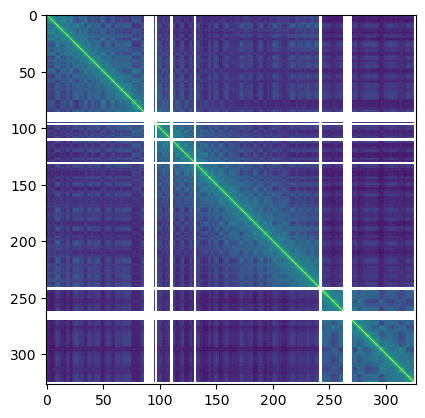

In [9]:
plt.imshow(np.log2(clr.matrix()[:]))

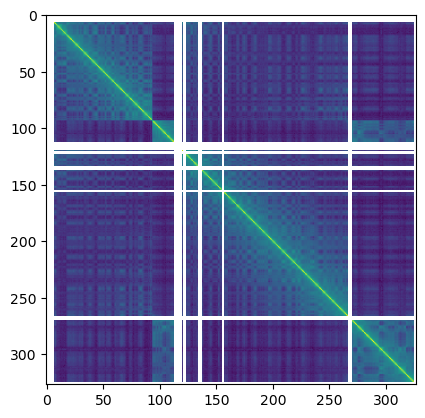

In [10]:
plt.imshow(np.log2(clr_new.matrix()[:]))

In [11]:
clr_new.chroms()[:]

,name,length
0,fake_chrom1,119000000
1,fake_chrom2,206450970


In [12]:
# Note that due to bins at the ends of chromosomes not having a "normal" length, bins after reordering can have strange coordinates, although they are still the same length
clr_new.bins()[:]

,chrom,start,end,weight
0,fake_chrom1,0,1000000,NaN
1,fake_chrom1,1000000,2000000,NaN
2,fake_chrom1,2000000,3000000,NaN
3,fake_chrom1,3000000,4000000,NaN
4,fake_chrom1,4000000,5000000,NaN
...,...,...,...,...
322,fake_chrom2,202193529,203193529,0.002830
323,fake_chrom2,203193529,204193529,0.003012
324,fake_chrom2,204193529,205193529,0.003727
325,fake_chrom2,205193529,206193529,0.003376


## New view with subset of regions

In [13]:
new_view = hg38_arms.iloc[[0, 3]].reset_index(drop=True).copy()
# Note that we don't create new chromosome names and orientations, they will be retained as were before:
new_view = bioframe.trim(new_view, hg38_chromsizes)
new_view

,chrom,start,end,name
0,chr2,0,94000000,chr2_p
1,chr17,25000000,83257441,chr17_q


In [14]:
rearrange_cooler(clr, new_view, 'test_reordered_subset.cool', new_chrom_col=None, orientation_col=None, assembly='hg38_custom')

INFO:root:Rearranged bins
INFO:root:Created bin mapping
INFO:root:Creating a new cooler
INFO:root:Processed 100.00% pixels
INFO:root:Created a new cooler at test_reordered_subset.cool


In [15]:
clr_new = cooler.Cooler('test_reordered_subset.cool')

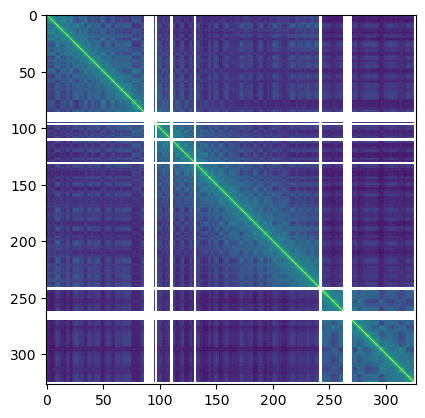

In [16]:
plt.imshow(np.log2(clr.matrix()[:]))

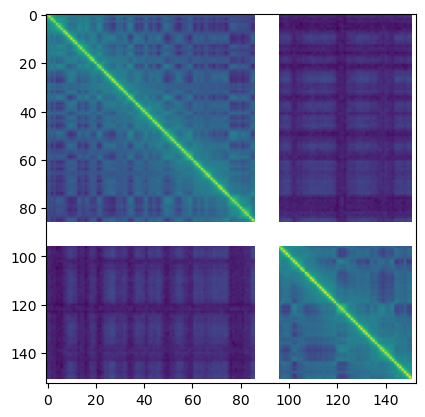

In [17]:
plt.imshow(np.log2(clr_new.matrix()[:]))

In [18]:
clr_new.chroms()[:]

,name,length
0,chr2,94000000
1,chr17,58257441


In [19]:
# Note that due to bins at the ends of chromosomes not having a "normal" length, bins after reordering can have strange coordinates, although they are still the same length
clr_new.bins()[:]

,chrom,start,end,weight
0,chr2,0,1000000,0.002441
1,chr2,1000000,2000000,0.002435
2,chr2,2000000,3000000,0.002728
3,chr2,3000000,4000000,0.001755
4,chr2,4000000,5000000,0.002474
...,...,...,...,...
148,chr17,54000000,55000000,0.002830
149,chr17,55000000,56000000,0.003012
150,chr17,56000000,57000000,0.003727
151,chr17,57000000,58000000,0.003376


In [20]:
clr_new.info['genome-assembly']

'hg38_custom'